In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.simplefilter('ignore')

### Задание №1

Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_w = data.resample('W').mean()
data_w.tail()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,3.000000,11.500000,0.142857,0.142857,0.142857
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-29,36581.821429,2018.0,7.000000,26.000000,3.0,207.000000,30.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-08-05,36568.804124,2018.0,7.505155,15.865979,3.0,212.525773,31.0,1.525773,11.381443,0.000000,0.000000,0.000000


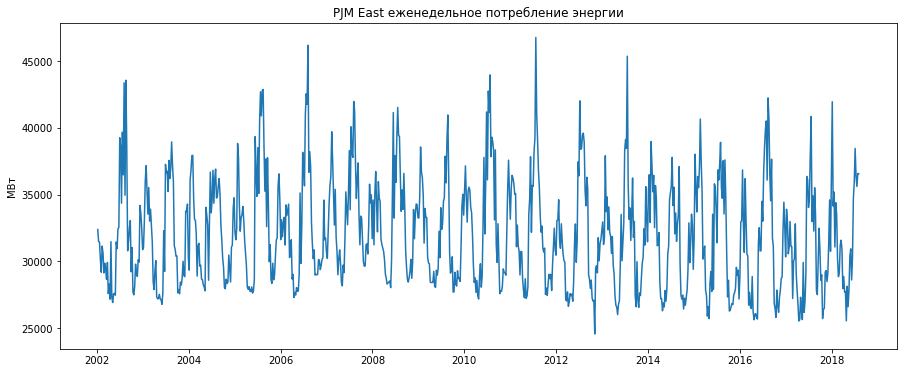

In [4]:
plt.figure(figsize =(15, 6))
plt.plot( data_w.index, data_w['PJME_MW'].values)
plt.title('PJM East еженедельное потребление энергии')
plt.ylabel ('МВт');

### Задание №2

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты моделирования ARIMA.

In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [6]:
data_exp_1 = exponential_smoothing(data_w['PJME_MW'], 0.05)

df = pd.DataFrame(data_exp_1, index=data_w.index)

df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values

df.fillna(0)

df.head(10)

,0,t,t1,t2
Date,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000
2002-01-13,32346.922142,32392.160839,0.000000,0.000000
2002-01-20,32302.220083,32346.922142,32392.160839,0.000000
2002-01-27,32194.185567,32302.220083,32346.922142,32392.160839
2002-02-03,32044.300693,32194.185567,32302.220083,32346.922142
2002-02-10,31999.611551,32044.300693,32194.185567,32302.220083
2002-02-17,31930.459248,31999.611551,32044.300693,32194.185567
2002-02-24,31791.142833,31930.459248,31999.611551,32044.300693
2002-03-03,31695.036287,31791.142833,31930.459248,31999.611551


In [7]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [8]:
train, test = split_data(df, '2017-01-01')

In [9]:
h = 4

In [10]:
X_train_4 = train.iloc[:-h,:]
y_train_4 = train[df.columns[0]].values[h:]
X_test_4 = test.iloc[:-h,:]
y_test_4 = test[df.columns[0]].values[h:]

In [11]:
X_train_4

,0,t,t1,t2
Date,,,,
2002-01-06,32392.160839,0.000000,0.000000,0.000000
2002-01-13,32346.922142,32392.160839,0.000000,0.000000
2002-01-20,32302.220083,32346.922142,32392.160839,0.000000
2002-01-27,32194.185567,32302.220083,32346.922142,32392.160839
2002-02-03,32044.300693,32194.185567,32302.220083,32346.922142
2002-02-10,31999.611551,32044.300693,32194.185567,32302.220083
2002-02-17,31930.459248,31999.611551,32044.300693,32194.185567
2002-02-24,31791.142833,31930.459248,31999.611551,32044.300693
2002-03-03,31695.036287,31791.142833,31930.459248,31999.611551


In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

In [14]:
model_gb.fit(X_train_4, y_train_4) 
X_test_pred_gb = model_gb.predict(X_test_4)

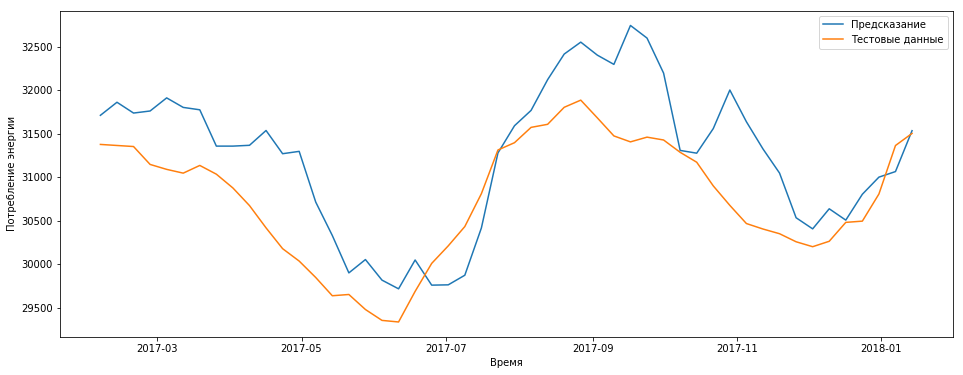

Ошибка градиентного бустинга :   1.723164334444495 %


In [15]:
plt.figure( figsize=(16, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h: h + 50], X_test_pred_gb[: 50], label='Предсказание')
plt.plot(test.index[h: h + 50], y_test_4[: 50], label='Тестовые данные')
plt.legend()
plt.show()

er_g_4 = mean_absolute_percentage_error(y_true=y_test_4, y_pred=X_test_pred_gb)

print('Ошибка градиентного бустинга :  ', er_g_4, '%')

In [16]:
%%time
mod = sm.tsa.statespace.SARIMAX(X_train_4[0],
                                order=[4,1,3],
                                seasonal_order=[4,1,2,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 7950.406270355344
CPU times: user 19min 40s, sys: 5.68 s, total: 19min 45s
Wall time: 4min 59s


### Задание №3

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты моделирования ARIMA.

### Задание №4

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки bp 4-х точек.

### Задание №5

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

### Задание №6

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.